# WorldMet vs AEMET

Comparar los datos que se optienen mediante `worldmet` que proceden de [NOAA](https://www.noaa.gov/) con los que se obtienen desde la API de [AEMET](https://opendata.aemet.es/centrodedescargas/inicio). La variables que se obtienen mediante las distintas fuentes no son las mismas, por lo que la comparacion se realiza entre variables comunes. Para este caso se han escogido: _Velocidad del viento_, _temperatura_, _precipitacion_, _radiacion_ y _Humedad_.

Hay que tener en cuenta que mientras que `worldmet` te permite obtener los datos con resolucion horaria, AEMET solo te permite tener los datos diarios, por lo que se debera hacer la media diaria a los datos de `worldmet` para una correcta comparacion, aunque no se sabe el metodo utilizado por AEMET para obtener los datos diarios.

|     Variable      |  AEMET   | WorldMet |
|:-----------------:|:--------:|:--------:|
| Temperatura media |   tmed   | air_temp |
| Velocidad Viento  | velmedia |    ws    |
| Direccion viento  |   dir    |    wd    |
|  Precipitacion    |   prec   |  precip  |
|    Radiacion      |   sol    |    -     |
| Humedad Relativa  |    -     |    RH    |

La compracion entre ambos datasets se realiza con los datos de la estacion meteorologica de SANTANDER AEROPUERTO.

In [1]:
setwd("~/Repositories/AirQualityCOVID")

source("src/general.R")

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
suppressMessages(library(worldmet))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

## Datos de WorldMet

In [4]:
variables.wmt <- c("air_temp", "ws", "precip")

In [5]:
dataMto <- importNOAA(code = "080210-99999",
                      year = 2013:2020,
                      hourly = TRUE,
                      n.cores = 6
                     )
head(dataMto)

code,station,date,latitude,longitude,elev,ws,wd,air_temp,atmos_pres,⋯,cl_2,cl_3,cl,cl_1_height,cl_2_height,cl_3_height,precip_12,precip_6,precip,pwc
<fct>,<fct>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
080210-99999,"SANTANDER, SP",2013-01-01 04:00:00,43.42706,-3.820006,4.87,8.7,280.0000,11.0,NA,⋯,NA,NA,4.0,1800,NA,NA,NA,NA,NA,NA
080210-99999,"SANTANDER, SP",2013-01-01 05:00:00,43.42706,-3.820006,4.87,8.0,276.1277,11.0,NA,⋯,4.0,NA,4.0,1650,1800,NA,NA,NA,NA,NA
080210-99999,"SANTANDER, SP",2013-01-01 06:00:00,43.42706,-3.820006,4.87,7.2,272.9441,12.2,1017.4,⋯,5.5,NA,5.5,1170,1560,NA,NA,NA,NA,NA
080210-99999,"SANTANDER, SP",2013-01-01 07:00:00,43.42706,-3.820006,4.87,5.1,265.0000,11.0,NA,⋯,7.0,NA,7.0,1050,1545,NA,NA,NA,NA,NA
080210-99999,"SANTANDER, SP",2013-01-01 08:00:00,43.42706,-3.820006,4.87,3.6,250.0000,11.0,NA,⋯,7.0,NA,7.0,900,1200,NA,NA,NA,NA,NA
080210-99999,"SANTANDER, SP",2013-01-01 09:00:00,43.42706,-3.820006,4.87,6.7,270.0000,11.5,1019.5,⋯,7.0,NA,7.0,975,1800,NA,NA,NA,3.333333,NA


#### Medias diarias de las variables de estudio

In [6]:
dataMto$date <- as_date(floor_date(dataMto$date, unit="day"))
new.df <- data.frame()

for (nm in variables.wmt) {
    means.dy <- aggregate(dataMto[,nm], 
                          by=list(date=dataMto$date), mean, na.rm=TRUE)
    
    new.df <- rbind(new.df,
                    data.frame(date=means.dy$date,
                               source=rep("worlmet", nrow(means.dy)),
                               variable=rep(nm, nrow(means.dy)),
                               values=means.dy[, nm])
                   )
}

## Datos de AEMET

In [7]:
variables.aemet <- c("tmed", "velmedia", "prec")

In [8]:
data.aemet <- read.csv("data/AEMET/prueba.csv")
data.aemet$fecha <- ymd(data.aemet$fecha)
head(data.aemet)

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
,<date>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-12-31,1109,SANTANDER AEROPUERTO,CANTABRIA,3,7.4,0,3.2,23:59,11.5,16:15,23,0.6,6.1,18:20,6.9,1032.9,0,1029.2,24
2,2017-01-01,1109,SANTANDER AEROPUERTO,CANTABRIA,3,7.5,0,1.8,05:30,13.2,15:30,23,0.3,4.2,23:20,6.2,1029.2,0,1017.3,24
3,2017-01-02,1109,SANTANDER AEROPUERTO,CANTABRIA,3,8.7,0,4.0,02:10,13.4,-2,20,2.5,11.4,05:40,2.6,1022.3,-2,1016.3,4
4,2017-01-03,1109,SANTANDER AEROPUERTO,CANTABRIA,3,7.5,0,3.2,08:30,11.8,-2,99,1.4,7.2,-2,7.0,1028.0,-2,1022.0,0
5,2017-01-04,1109,SANTANDER AEROPUERTO,CANTABRIA,3,5.8,0,1.5,06:10,10.2,-2,6,0.6,5.6,14:01,1.3,1029.4,-2,1027.5,0
6,2017-01-05,1109,SANTANDER AEROPUERTO,CANTABRIA,3,6.6,0,2.0,08:10,11.2,14:10,8,3.6,9.7,11:30,7.2,1031.9,-2,1028.9,1


In [9]:
new.df.aemet <- data.frame()

for (i in 1:length(variables.aemet)) {
    
    new.df.aemet <- rbind(new.df.aemet,
                    data.frame(date=data.aemet$fecha,
                               source=rep("aemet", 
                                          length(data.aemet[, "fecha"])),
                               variable=rep(variables.wmt[i], 
                                            length(data.aemet[, "fecha"])),
                               values=data.aemet[, variables.aemet[i]])
                   )
}

head(new.df.aemet)

,date,source,variable,values
,<date>,<chr>,<chr>,<dbl>
1,2016-12-31,aemet,air_temp,7.4
2,2017-01-01,aemet,air_temp,7.5
3,2017-01-02,aemet,air_temp,8.7
4,2017-01-03,aemet,air_temp,7.5
5,2017-01-04,aemet,air_temp,5.8
6,2017-01-05,aemet,air_temp,6.6


## Juntar Ambos dataSets

In [10]:
all.meteo <- rbind(new.df, new.df.aemet)

head(all.meteo)

,date,source,variable,values
,<date>,<chr>,<chr>,<dbl>
1,2013-01-01,worlmet,air_temp,11.059649
2,2013-01-02,worlmet,air_temp,10.467544
3,2013-01-03,worlmet,air_temp,9.697368
4,2013-01-04,worlmet,air_temp,7.994737
5,2013-01-05,worlmet,air_temp,7.771053
6,2013-01-06,worlmet,air_temp,9.155263


## Diferencias 

In [18]:
for (var in levels(as.factor(all.meteo$variable))) {
    data.1 <- all.meteo[all.meteo$source == "worlmet" &
                        all.meteo$variable == var, c("date", "values")]
    data.2 <- all.meteo[all.meteo$source == "aemet" &
                        all.meteo$variable == var, c("date", "values")]
    
    diff <- merge(data.1, data.2,
                  by = "date", all.x=T, all.y=T)
    
    print(paste(var, mean((diff$values.x - diff$values.y), na.rm=TRUE), sep=" => "))
}

[1] "air_temp => -0.440818272069665"
[1] "precip => 0.722141517019566"
[1] "ws => -0.204415981988288"


## Representar ambos datasets

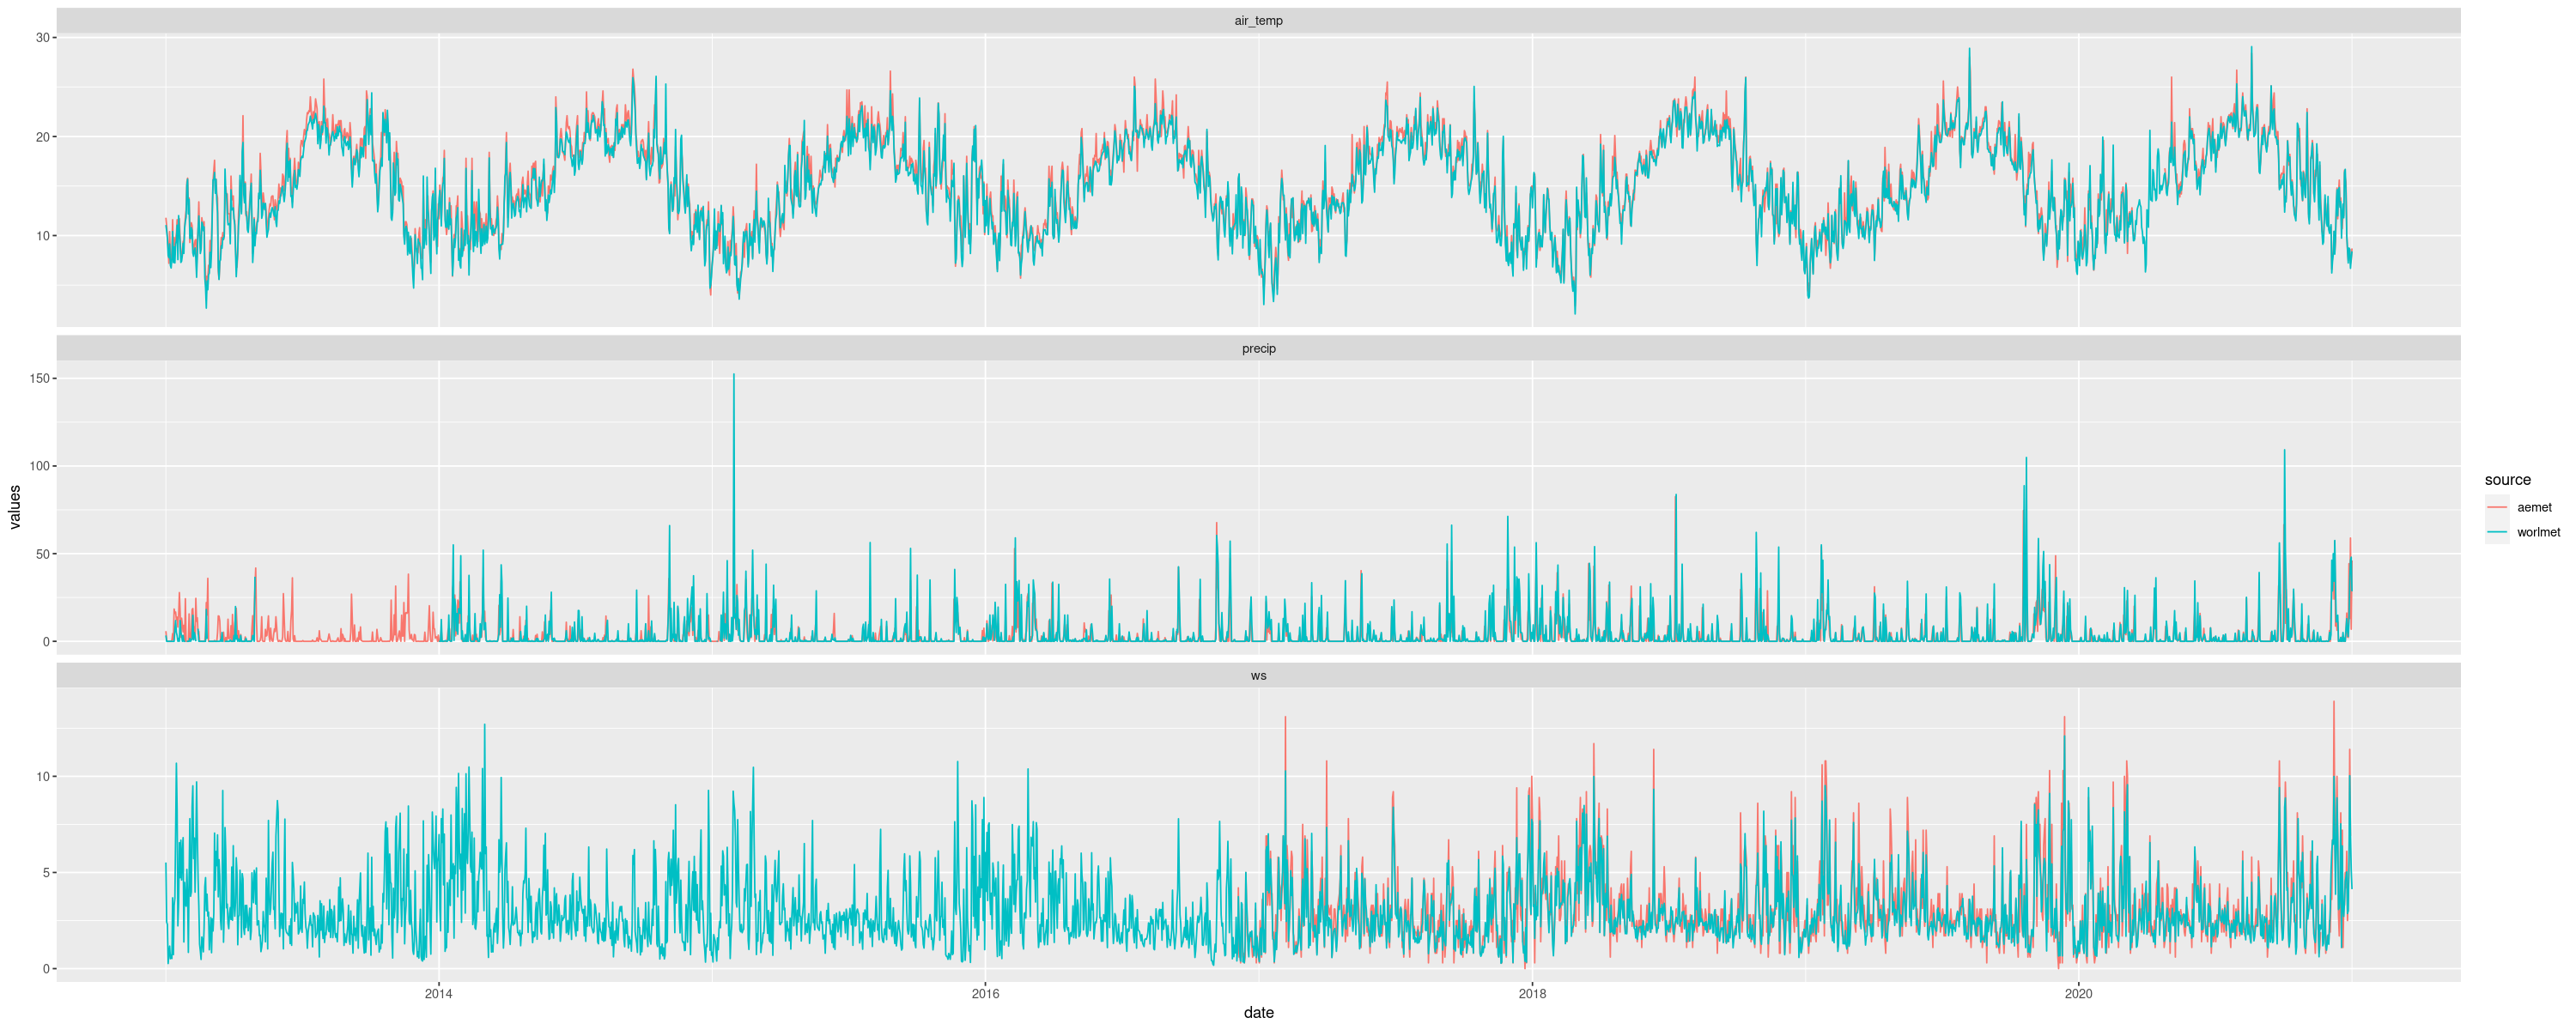

In [19]:
ggplot(data=all.meteo) +
    geom_line(aes(x=date, y=values, color=source)) + 
facet_wrap(~variable, ncol=1, scales = "free_y")